# Stochastic polynomial methods

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

To experiment with these methods, let's consider the problem of determining the statistics of $Y = \exp{X}$, where $X \sim \mathcal{N}(0,1)$.  Since $X$ is Gaussian, the orthogonal basis will be Hermite polynomials, and the optimal quadrature rules are Gauss-Hermite rules.  

Since $g(x) = \exp x$ is monotonically increasing, we can also solve this problem algebraically (homework exercise!).  Note that $Y$ is also known as the log-normal variable, $Y\sim \log\mathcal{N}(0,1)$.

## Stochastic numerical quadrature

Since input $X \sim \mathcal{N}(0,1)$, Gauss-Hermite quadrature is optimal.  This is implemented in scipy in `numpy.polynomial.hermite`:

https://docs.scipy.org/doc/numpy/reference/generated/numpy.polynomial.hermite.hermgauss.html

which returns Gauss-Hermite nodes and weights for integrals of the form:
$$
I_1[f] = \int_{-\infty}^{\infty} f(x) e^{-x^2}\,\mathrm{d}x.
$$
i.e. the "physicists'" Hermite.  However we're interested in integrals of the form
$$
I_2[f] = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty} f(x) e^{-t^2/2}\,\mathrm{d}t
$$
given which $\mathbb{E}_X f(X) = I_2[f]$.  The difference between $I_1$ and $I_2$ is just a change-of-variables $t = x\sqrt{2}$ (which changes the nodes), and a constant factor $\sqrt\pi$ (which changes the weights).

In [2]:
from numpy.polynomial.hermite import hermgauss

def scaled_hermite(M):
    x_nodes, x_weights = hermgauss(M+1)
    t_nodes = x_nodes * np.sqrt(2)
    t_weights = x_weights / np.sqrt(np.pi)
    return t_nodes, t_weights

def quad_hermite(f, M):
    t_nodes, t_weights = scaled_hermite(M)
    return np.sum(t_weights * f(t_nodes))  # Implement the quad-rule

M = 8
print('E1 =', quad_hermite(lambda x: 1, M), "==", 1)
print('Ex^2 =', quad_hermite(lambda x: x**2, M), "==", 1)

E1 = 1.0 == 1
Ex^2 = 1.0000000000000002 == 1


In the last lines we check $\mathbb{E}_X 1 = 1$ (so weights are scaled properly), and $\mathbb{E}_X X^2 = 1$ (so also nodes are scaled well).  If you're working with a general $X\sim \mathcal(\mu,\sigma^2)$, then you need to do something similar, and afterwards you should check that $\mathbb{V}_XX = \mathbb{E}_X X^2 - \mu^2 = \sigma^2$.

Let's look at the nodes:

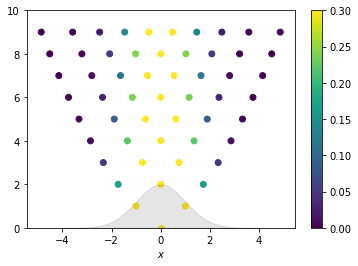

In [3]:
for M in range(10):
    nodes, weights = scaled_hermite(M)
    plt.scatter(nodes, np.ones(M+1)*M, c=weights, marker='o', vmin=0, vmax=0.3)
xx = np.linspace(-4,4,101)
plt.fill_between(xx, np.exp(-xx**2/2)*2, color='k', alpha=0.1)
plt.xlabel(r'$x$'), plt.ylim(0,10)
plt.colorbar()

Finally, let's check the promised degree-of-precision is achieved.  First we need some exact reference:
$$
\mathbb{E}_X X^M = \begin{cases} (M-1)!!=1\cdot3\cdot\dots\cdot(M-1) & M\: \mathrm{even}\\
0 & M\: \mathrm{odd}\end{cases}
$$

In [7]:
def exact(M):
    if M % 2 == 1: return 0.
    return np.prod([i for i in range(1,M,2)])

M = 5
max_degree = 2*M + 1
print('%4s %15s %15s %15s' % ('f', 'quad', 'exact', 'error'))
for deg in range(max_degree+4):
    Q = quad_hermite(lambda x: x**deg, M)
    I = exact(deg)
    error = I - Q
    print('%4s %15.4g %15.4g %15.4g' % (f'x^{deg}', Q, I, error))
    if deg == max_degree: print('----------------')

   f            quad           exact           error
 x^0               1               1        1.11e-16
 x^1       1.388e-17               0      -1.388e-17
 x^2               1               1       5.551e-16
 x^3       1.388e-17               0      -1.388e-17
 x^4               3               3        2.22e-15
 x^5               0               0               0
 x^6              15              15       1.243e-14
 x^7               0               0               0
 x^8             105             105       8.527e-14
 x^9      -1.421e-14               0       1.421e-14
x^10             945             945       9.095e-13
x^11               0               0               0
----------------
x^12            9675        1.04e+04             720
x^13               0               0               0
x^14       1.042e+05       1.351e+05       3.096e+04


Now evaluate statistics of $Y = \exp X$ (exact values are $\mathbb{E}Y = \exp\frac{1}{2}$, $\mathbb{V}Y = (e - 1) e$).

In [10]:
M = 3
ExpY_exact = np.exp(0.5)
VarY_exact = np.e * (np.e - 1)
ExpY = quad_hermite(lambda x: np.exp(x),M)
VarY = quad_hermite(lambda x: np.exp(x)**2,M) - ExpY**2
print('E y =', ExpY, '==', ExpY_exact)
print('V y =', VarY, '==', VarY_exact)

E y = 1.6479689600489622 == 1.6487212707001282
V y = 4.279511573756203 == 4.670774270471604


And look at convergence:

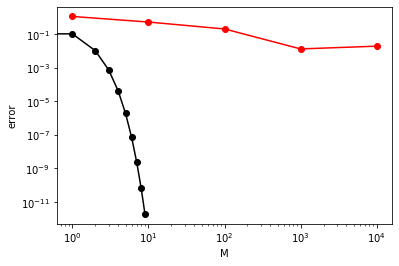

In [14]:
MM = range(10)
err = np.zeros(10)
for i,M in enumerate(MM):
    err[i] = np.abs(quad_hermite(lambda x: np.exp(x),M) - ExpY_exact)
plt.plot(MM, err, '-ok')
plt.xlabel('M'); plt.ylabel('error'); plt.yscale('log')

NN = 10**np.arange(5)
err_MC = np.zeros(5)
for i,N in enumerate(NN):
    ExpY_MC = np.sum(np.exp(np.random.normal(size=N)))/N
    err_MC[i] = np.abs(ExpY_MC - ExpY_exact)
plt.plot(NN, err_MC, '-or')
plt.xscale('log')

## Orthogonal polynomials (Hermite)

So now let's build the basis $\phi_i(x)$ of Hermite polynomials, and check it has the expected properties, namely 
$$\mathbb{E}_X \phi_i \phi_j = \delta_{ij} \gamma_i$$ 
and 
$$\mathbb{E}_X \phi_i = 0$$ 
for $i\geq 1$.  We use `numpy.polynomial.hermite` again, this time `hermval()`: 

https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.polynomial.hermite.hermval.html#numpy.polynomial.hermite.hermval

Again, these are the physics Hermites, so we need to scale them.  Let's plot them first:

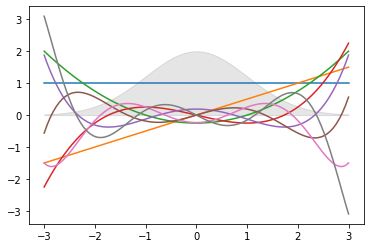

In [25]:
xx = np.linspace(-3,3,101)
from numpy.polynomial.hermite import hermval

def hermval_stats(x, i, M):
    c = np.zeros(M+1); c[i] = 1.
    return hermval(x / np.sqrt(2), c) / 2**(i/2)

M = 8
C = np.eye(M)
for i in range(M):
    plt.plot(xx, hermval_stats(xx, i, M)/2**i)
plt.fill_between(xx, np.exp(-xx**2/2)*2, color='k', alpha=0.1)


Now check statistics:

In [26]:
M = 8
for i in range(M+1):
    def fn(x): return hermval_stats(x,i,M)
    print(f'E_phi_{i} =', quad_hermite(fn, M), '=', int(i==0))

E_phi_0 = 1.0 = 1
E_phi_1 = -2.6603610807363065e-17 = 0
E_phi_2 = 1.494030593685025e-16 = 0
E_phi_3 = 5.2475385148298415e-17 = 0
E_phi_4 = 3.0357660829594124e-17 = 0
E_phi_5 = 3.122502256758253e-17 = 0
E_phi_6 = -2.8033131371785203e-15 = 0
E_phi_7 = 2.7755575615628914e-17 = 0
E_phi_8 = 4.390932062392494e-14 = 0


In [27]:
M = 8
print('E( phi_i phi_j ) = ')
for i in range(M+1):
    for j in range(M+1):
        def fn(x): return hermval_stats(x,i,M) * hermval_stats(x,j,M)
        print('%6.1f' % quad_hermite(fn, M), end='')
    print()

E( phi_i phi_j ) = 
   1.0  -0.0   0.0   0.0   0.0   0.0  -0.0   0.0   0.0
  -0.0   1.0  -0.0   0.0   0.0  -0.0   0.0   0.0  -0.0
   0.0  -0.0   2.0  -0.0  -0.0   0.0   0.0  -0.0   0.0
   0.0   0.0  -0.0   6.0  -0.0  -0.0   0.0   0.0  -0.0
   0.0   0.0  -0.0  -0.0  24.0   0.0   0.0   0.0   0.0
   0.0  -0.0   0.0  -0.0   0.0 120.0   0.0   0.0   0.0
  -0.0   0.0   0.0   0.0   0.0   0.0 720.0   0.0   0.0
   0.0   0.0  -0.0   0.0   0.0   0.0   0.05040.0   0.0
   0.0  -0.0   0.0  -0.0   0.0   0.0   0.0   0.040320.0


## Galerkin representation

Finally, let's see what the Galerkin surrogate looks like...

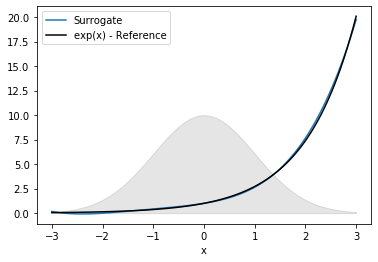

In [32]:
M = 4
xx = np.linspace(-3,3,101)

def galerkin_surrogate(xx, fn):
    sum = np.zeros(xx.shape)
    for i in range(M+1):
        gamma = quad_hermite(lambda t: hermval_stats(t, i, M)**2, M)
        y_coeff = quad_hermite(lambda t: fn(t) * hermval_stats(t, i, M), M)
        sum += y_coeff * hermval_stats(xx, i, M) / gamma
    return sum

p = galerkin_surrogate(xx, lambda x: np.exp(x))
plt.plot(xx, p, label='Surrogate')
plt.plot(xx, np.exp(xx), '-k', label='exp(x) - Reference')
plt.fill_between(xx, np.exp(-xx**2/2)*10, color='k', alpha=0.1)
plt.xlabel('x')
plt.legend()